In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [50]:
# Task:
# create 30x30 gaussian noise
# then add vertical and horizontal bars
n = 1000
size = 30
data = np.random.normal(size=(n, size, size))
labels = np.zeros(data.shape[0])
for i, img in enumerate(data):
    choice = np.random.choice(np.arange(2,28))
    choice2 = np.random.choice(np.arange(1,6))
    if np.random.rand() > 0.5:
        img[choice:choice+choice2, :] = 10
        labels[i] = 0 # horizontal
    else:
        img[:, choice:choice+choice2] = 10
        labels[i] = 1 # vertical


TypeError: Invalid shape (1, 30, 30) for image data

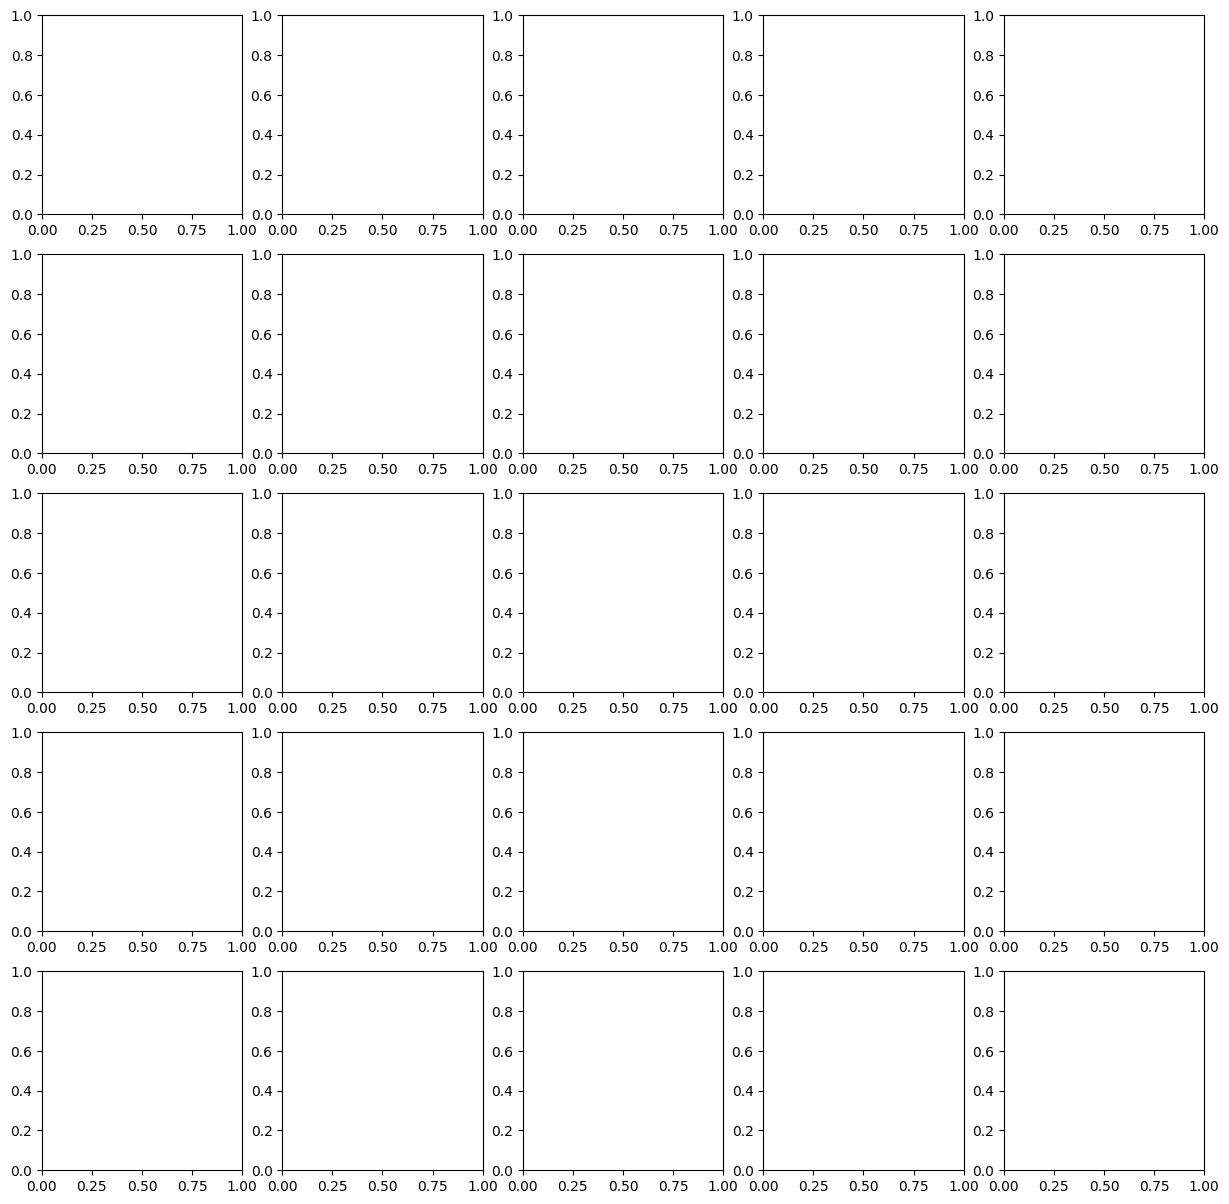

In [51]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for img in range(5):
    for img2 in range(5):
        ax[img][img2].imshow(data[img+img2])
        ax[img][img2].axis('off')
        ax[img][img2].set_title(labels[img+img2])

In [52]:
data = data.reshape(-1, 1, 30, 30)

In [77]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1) #15 x 15
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) # 7x7
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)# 3x3
        self.bc1 = nn.BatchNorm2d(64)
        self.bc2 = nn.BatchNorm2d(128)
        self.bc3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(256 * 3 * 3, 128)
        self.linear2 = nn.Linear(128, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.max_pool(self.relu(self.bc1(self.conv1(x))))
        x = self.max_pool(self.relu(self.bc2(self.conv2(x))))
        x = self.max_pool(self.relu(self.bc3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.relu(self.linear2(x))
        return x


In [89]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float), torch.tensor(train_y, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_x, dtype=torch.float), torch.tensor(test_y, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=True)

In [90]:
model = Net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
X,y = next(iter(train_loader))
# y_pred = model(X)
# print(y_pred)
y

tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0])

In [112]:
def train_the_model():
    model = Net()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = []
    test_loss = []
    train_acc = []
    test_acc = []
    for epoch in range(2):
        model.train()
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_fn(yHat, y)

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (torch.argmax(yHat, dim=1) == y).float().sum()
            train_acc.append(100* acc / y.shape[0])


        with torch.no_grad():
            model.eval()
            X, y = next(iter(test_loader))
            yHat = model(X)
            loss = loss_fn(yHat, y)
            test_loss.append(loss.item())
            acc = (torch.argmax(yHat, dim=1) == y).float().sum()
            test_acc.append(100 * acc / y.shape[0])

    return train_acc, test_acc, losses, test_loss, model

In [113]:
 train_acc, test_acc, losses, test_loss, model = train_the_model()

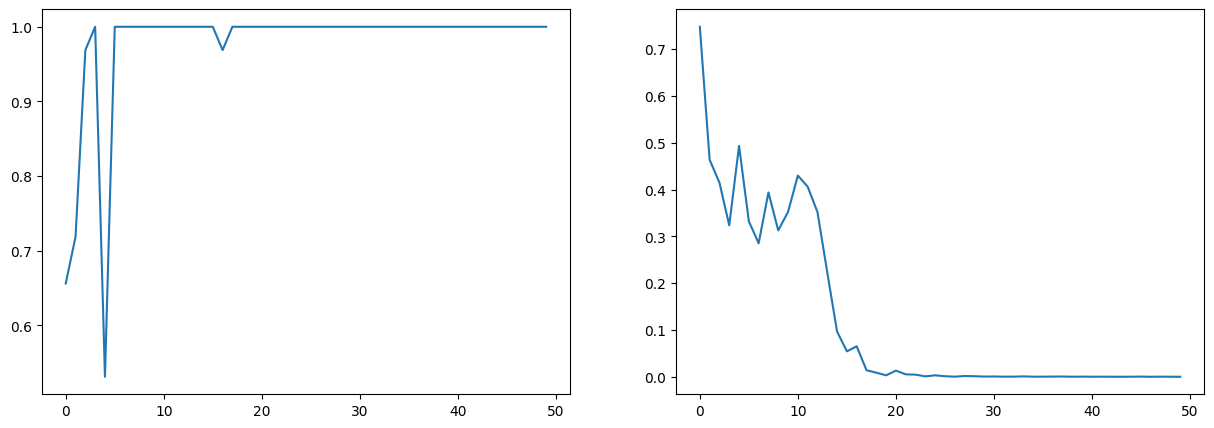

In [121]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(train_acc)
ax[1].plot(losses)

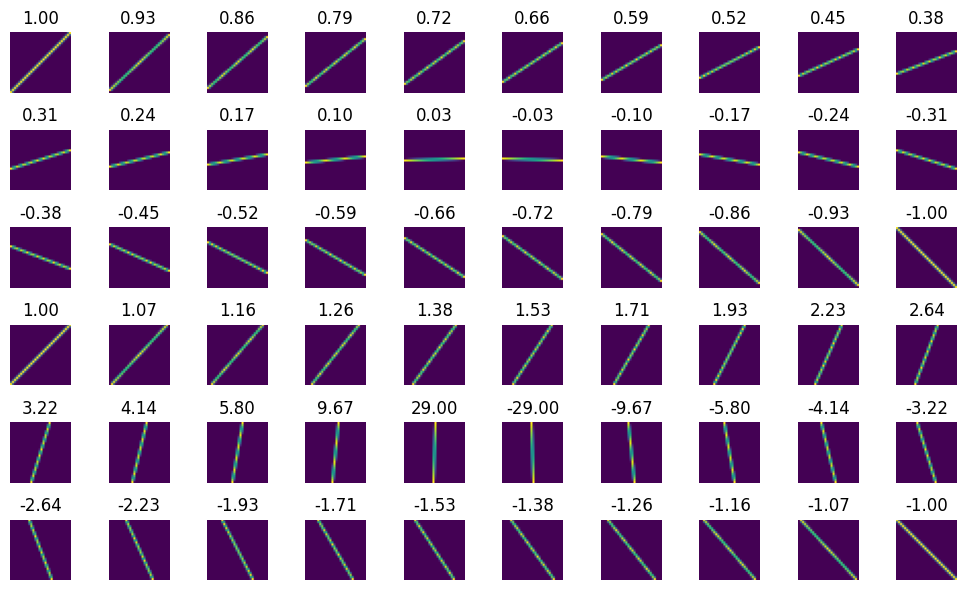

In [160]:
### create lines in images
imgSize = 30
from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

In [168]:
# run the images through the model

# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...
ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx, :, :, :].astype(np.float32))

# now generate the prediction (horizontal or vertical)
model.eval()
yHat = torch.sigmoid(model(imgT)).detach()

# plot the results (make sure the slopes use the same randomization)
# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
    # Upewnij się, że yHat[i] to skalar
    pred = yHat[i].item()  # lub yHat[i, 0].item(), jeśli yHat ma wymiar (batch_size, 1)
    if pred > 0.5:
        plt.plot([slopes[ridx[i]], slopes[ridx[i]]], [1, pred], 'r')
    else:
        plt.plot([slopes[ridx[i]], slopes[ridx[i]]], [0, pred], 'g')

plt.plot(slopes[ridx], yHat.squeeze(), 'ko')  # Dodanie .squeeze() dla odpowiedniego wymiaru
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' % torch.mean(100 * (yHat > 0.5).float()).item())
plt.ylim([0, 1])
plt.xlim([-10, 10])  # note: this actually clips two data points
plt.show()


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

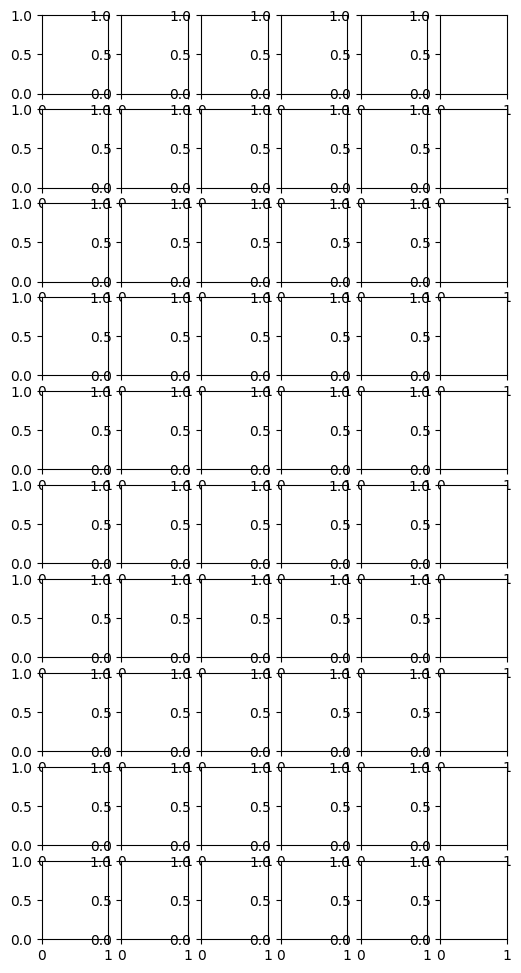

In [164]:

fig, ax = plt.subplots(10, 6, figsize=(6, 12))

for i, a in enumerate(ax.flatten()):

    # show the line-image (make sure to use the randomization index)
    if yHat[i] > .5:
        a.imshow(imgs[ridx[i], 0, :, :], origin='lower', cmap='Reds')
    else:
        a.imshow(imgs[ridx[i], 0, :, :], origin='lower', cmap='Greens')

    # and the title
    title = '"Vert."' if yHat[i].detach() > .5 else '"Horiz."'
    a.set_title(title)
    a.axis('off')

plt.tight_layout()
plt.show()